In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
import joblib
# from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Problem Description:
The goal is to classify tweets into real disaster ones labelled as 1 and non disaster ones labelled as 0 with the help of NLP model. 
The dataset contains 
1. train.csv with  7613 tweets with 5 columns as id, keyword, location,target, text.
2. test.csv with  3263 tweets with 4 columns same as train data except for target.
3. Sample submission csv file with id and label.

In [22]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [4]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [5]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [6]:
print(train_df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [7]:
print(test_df.head())

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


# EDA
After loading the data i will start with inspection of the data structure. Based on the that i will further continue with data cleaning procedure.

In [8]:
print("Training Data Shape:", train_df.shape)


Training Data Shape: (7613, 5)


In [9]:
print("\nSample Tweets:")
print(train_df[['text', 'target']].head())


Sample Tweets:
                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1


In [10]:
print("\nMissing Values in Train:")
print(train_df.isnull().sum())


Missing Values in Train:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [11]:
print("\nTarget Distribution:")
print(train_df['target'].value_counts(normalize=True) * 100)


Target Distribution:
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


Showing the visualizations here:

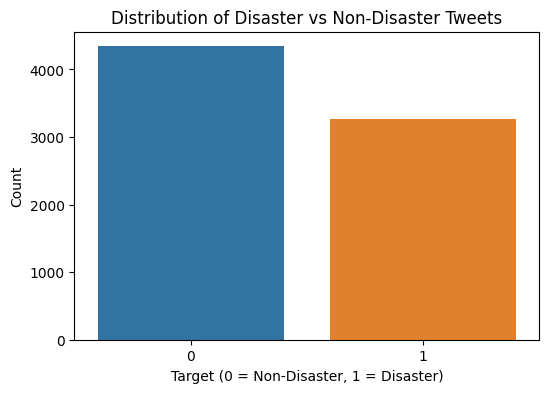

In [12]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)')
plt.ylabel('Count')
plt.show()

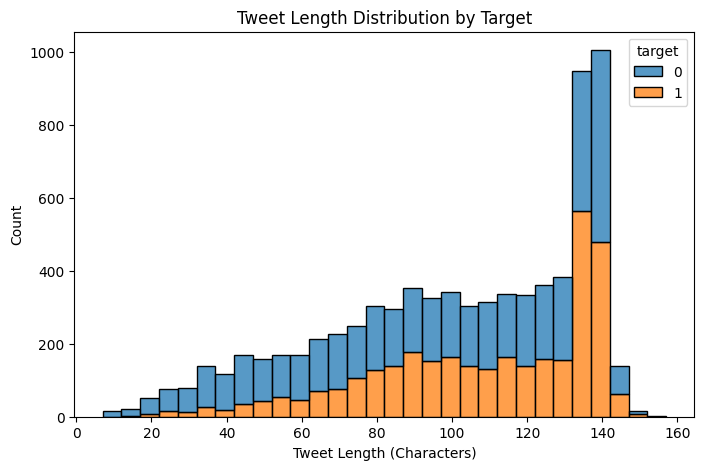

In [13]:
# Tweet length (characters)
train_df['text_length'] = train_df['text'].apply(len)
plt.figure(figsize=(8,5))
sns.histplot(data=train_df, x='text_length', hue='target', bins=30, multiple='stack')
plt.title('Tweet Length Distribution by Target')
plt.xlabel('Tweet Length (Characters)')
plt.ylabel('Count')
plt.show()

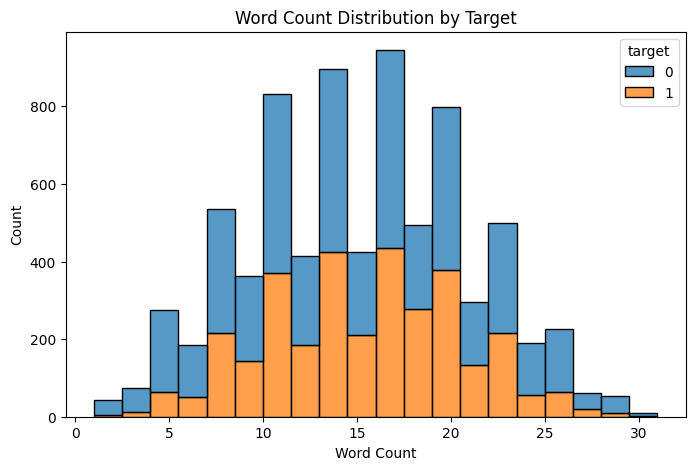

In [14]:
# Word count
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(data=train_df, x='word_count', hue='target', bins=20, multiple='stack')
plt.title('Word Count Distribution by Target')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.show()

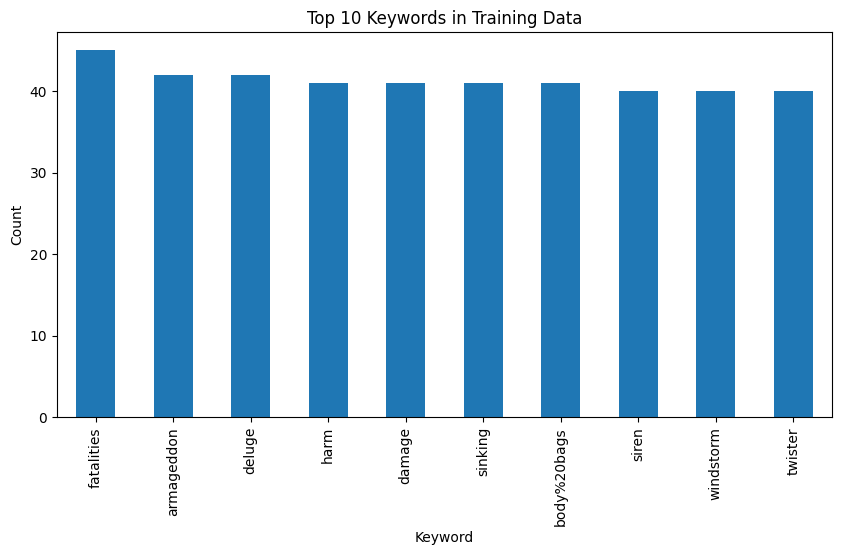

In [15]:
# Top 10 keywords
plt.figure(figsize=(10,5))
train_df['keyword'].value_counts()[:10].plot(kind='bar')
plt.title('Top 10 Keywords in Training Data')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.show()

Based on the inspection condcuted,the data is relatively clean but with few issues to address like 
1. Missing values in  keyword and location.
2. Text cleaning.
So, I am gonna remove the URLs, mentions and hashtags, convert text into lowercase preserving special characters and words. I will create new cloumn text_clean for modeling.

In [23]:
train_df['keyword'].fillna('unknown', inplace=True)
test_df['keyword'].fillna('unknown', inplace=True)

# Basic text cleaning
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)    # Remove mentions
    text = re.sub(r'#\w+', '', text)    # Remove hashtags
    text = text.lower()                 # Lowercase
    return text.strip()

train_df['text_clean'] = train_df['text'].apply(clean_text)
test_df['text_clean'] = test_df['text'].apply(clean_text)



In [24]:
# Drop 'location' column as 33% of the locations are not available.
train_df = train_df.drop(['location'], axis=1)
test_df = test_df.drop(['location'], axis=1)

print("Training Data Columns:", train_df.columns)
print("\nTest Data Columns:", test_df.columns)
print("\nSample Training Data:")
print(train_df.head())


Training Data Columns: Index(['id', 'keyword', 'text', 'target', 'text_clean'], dtype='object')

Test Data Columns: Index(['id', 'keyword', 'text', 'text_clean'], dtype='object')

Sample Training Data:
   id  keyword                                               text  target  \
0   1  unknown  Our Deeds are the Reason of this #earthquake M...       1   
1   4  unknown             Forest fire near La Ronge Sask. Canada       1   
2   5  unknown  All residents asked to 'shelter in place' are ...       1   
3   6  unknown  13,000 people receive #wildfires evacuation or...       1   
4   7  unknown  Just got sent this photo from Ruby #Alaska as ...       1   

                                          text_clean  
0  our deeds are the reason of this  may allah fo...  
1             forest fire near la ronge sask. canada  
2  all residents asked to 'shelter in place' are ...  
3  13,000 people receive  evacuation orders in ca...  
4  just got sent this photo from ruby  as smoke f...  


# Model 1
Based on the EDA, the data set is suitable for NLP with a focus on text. My plan of action would be to prepare the data for the model building by splitting the train data in 80:20 ratio where 80% goes for training and 20% goes for validation.Then i would build a TD-IDF + logistic regression model and tune the hyperparameters and evaluate the results.
Logistic regression is a basic model for classification. Let's start with this & later I can use advanced model like GRU on the tweet classification.
TDIDF is a preprocessing to make a vector of the dictionary words with it's corresponding positions for each tweet's set of words.


In [28]:
# == Prepare Data ==
X = train_df['text_clean']
y = train_df['target']
X_final_test = test_df['text_clean']

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# == Vectorization ==
print("\nVectorizing text with TF-IDF...")

#Initialize TF-IDF vectorizer
# Start with default parameters; we'll tune max_features and ngram_range
tfidf = TfidfVectorizer()

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)
print("Training TF-IDF Matrix Shape:", X_train_tfidf.shape)

# Transform validation and test data (using same vocabulary)
X_val_tfidf = tfidf.transform(X_val)
print("Validation TF-IDF Matrix Shape:", X_val_tfidf.shape)
X_final_test_tfidf = tfidf.transform(X_final_test)
print("Test TF-IDF Matrix Shape:", X_final_test_tfidf.shape)

# Inspect vocabulary
feature_names = tfidf.get_feature_names_out()
print("Vocabulary Size:", len(feature_names))
print("Sample Features:", feature_names[:10])


Vectorizing text with TF-IDF...
Training TF-IDF Matrix Shape: (6090, 12027)
Validation TF-IDF Matrix Shape: (1523, 12027)
Test TF-IDF Matrix Shape: (3263, 12027)
Vocabulary Size: 12027
Sample Features: ['00' '000' '0000' '00end' '00pm' '01' '02' '02pm' '03' '030']


In [29]:
# == Hyperparameter Tuning for Logistic Regression ==
print("\nTraining Logistic Regression with Grid Search...")

# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10]
}

# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=1000)

# Grid search
grid_search = GridSearchCV(
    logreg,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_tfidf, y_train)

best_logreg = grid_search.best_estimator_
print("\nBest Logistic Regression Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1 Score:", grid_search.best_score_)


Training Logistic Regression with Grid Search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best Logistic Regression Parameters: {'C': 10}
Best Cross-Validation F1 Score: 0.7342309162288039


In [19]:
# == Evaluate on Validation Set ==
val_preds = best_logreg.predict(X_val_tfidf)
val_f1 = f1_score(y_val, val_preds)
print(f"Validation F1 Score: {val_f1:.4f}")

Validation F1 Score: 0.7530


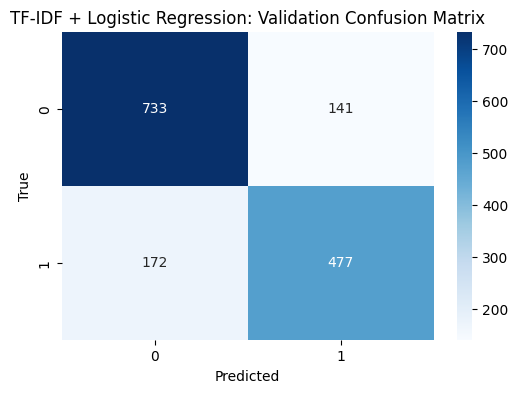

In [20]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('TF-IDF + Logistic Regression: Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Model1 with hyperparameter tuning


In [42]:
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=2000)

# Grid search
grid_search = GridSearchCV(
    logreg,
    param_grid,
    cv=10,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_tfidf, y_train)

best_logreg2 = grid_search.best_estimator_
print("\nBest Logistic Regression Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1 Score:", grid_search.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits

Best Logistic Regression Parameters: {'C': 10}
Best Cross-Validation F1 Score: 0.7384203407224377


In [44]:
# == Evaluate on Validation Set ==
val_preds2 = best_logreg2.predict(X_val_tfidf)
val_f2 = f1_score(y_val, val_preds2)
print(f"Validation F1 Score: {val_f2:.4f}")

Validation F1 Score: 0.7530


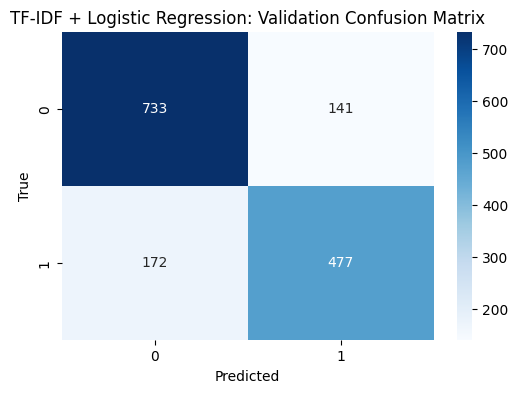

In [54]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, val_preds2)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('TF-IDF + Logistic Regression: Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Model2 GRU
Now I would like to use a GRU RNN which is simple than LSTM & should be fine for this 6k tweets. This is advanced than the earlier logistic regression as this would vectorize & remember the order of each word. This ordered vector of tweets contains more trivial information in an organized way & this helped us to get better accuracy & lower loss.

In [45]:
# Parameters
max_words = 4000  # Limit vocab size
max_len = 50      # Max tweet length (tweets are short in general & assuming 50 would be a sweet spot)
embedding_dim = 64

# Tokenize text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)  # X_train is the raw text
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

# Build GRU model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    GRU(32),
    Dense(1, activation='sigmoid')
])

# Compile and train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10, batch_size=32)



Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6088 - loss: 0.6425 - val_accuracy: 0.7932 - val_loss: 0.4655
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8548 - loss: 0.3614 - val_accuracy: 0.7774 - val_loss: 0.4768
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8856 - loss: 0.2897 - val_accuracy: 0.7728 - val_loss: 0.5089
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9134 - loss: 0.2296 - val_accuracy: 0.7518 - val_loss: 0.5743
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9314 - loss: 0.1842 - val_accuracy: 0.7538 - val_loss: 0.6409
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9448 - loss: 0.1395 - val_accuracy: 0.7498 - val_loss: 0.7392
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9550 - loss: 0.1194 - val_accuracy: 0.7584 - val_loss: 0.7998
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9637 - loss: 0.0950 - val_accuracy: 0.

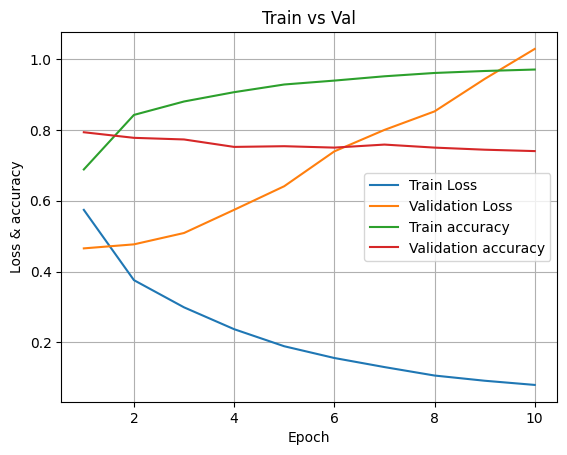

In [58]:
train_loss = history.history['loss']  
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss'] 
val_accuracy = history.history['val_accuracy']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss & accuracy')
plt.title('Train vs Val')
plt.legend()
plt.grid(True)
plt.show()

# Model2 GRU hyperparameter fine tuning

I am changing the hyper parameters of max tweet length, vocabulary size, epochs & try validating the model's accuracy & loss. This is improve the accuracy & reduce the loss & might even overfit.

In [52]:
# Parameters
max_words = 5000 # Limit vocab size
max_len = 60      # Max tweet length (tweets are short in general & assuming 60 would be a sweet spot)
embedding_dim = 64

# Tokenize text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)  # X_train is the raw text
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

# Build GRU model
model_gru2 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    GRU(40),
    Dense(1, activation='sigmoid')
])

# Compile and train
model_gru2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history2 = model_gru2.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=20, batch_size=32)



Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6291 - loss: 0.6281 - val_accuracy: 0.7663 - val_loss: 0.4792
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8546 - loss: 0.3551 - val_accuracy: 0.7774 - val_loss: 0.4787
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8997 - loss: 0.2640 - val_accuracy: 0.7682 - val_loss: 0.5434
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9234 - loss: 0.1972 - val_accuracy: 0.7695 - val_loss: 0.6036
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9466 - loss: 0.1485 - val_accuracy: 0.7492 - val_loss: 0.6982
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9540 - loss: 0.1274 - val_accuracy: 0.7571 - val_loss: 0.7549
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9651 - loss: 0.0961 - val_accuracy: 0.7689 - val_loss: 0.8587
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9708 - loss: 0.0876 - val_accuracy: 0.

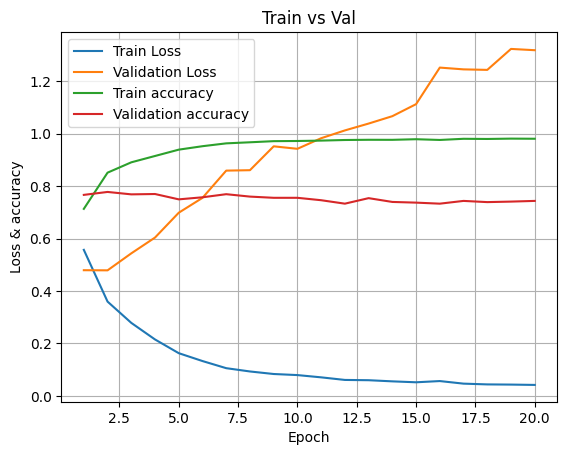

In [57]:
train_loss = history2.history['loss']  
train_accuracy = history2.history['accuracy']
val_loss = history2.history['val_loss'] 
val_accuracy = history2.history['val_accuracy']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss & accuracy')
plt.title('Train vs Val')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
X_test_seq = tokenizer.texts_to_sequences(test_df['text_clean'])
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
print("Test data shape:", X_test_pad.shape)

y_test_pred = model_gru2.predict(X_test_pad, verbose=1)
y_test_pred = (y_test_pred > 0.5).astype(int).flatten()

output_df = pd.DataFrame({
    'id': test_df['id'],
    'target': y_test_pred
})
output_df.to_csv('submission.csv', index=False)

Test data shape: (3263, 60)
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


# Results & analysis

Initially tried with a basic logistic regression & later I tried GRU model which performs better because it takes the order of the words in a tweet & had better accuracy. I tried tuning hyperparameters but it didn't effect much to the accuracy when validated on the test dataset.

# Conclusion

Logistic regression is a basic model but might not be suitable for tweets classification as the wording order matters to have better context of adjectives to it's corresponding nouns to better classify the tweet.
GRU is an interesting model & it worked better due to the contextual awareness & relationship between the words due to it's order. Would like to later use LSTM as well to see if it performs better over GRU. I tried tuning hyper parameter for the GRU model but it didn't much improve the performance